In [155]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

In [156]:
from core.data_repository import DataRepository
from pathlib import Path


data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN']

 2025-10-25 14:32:41 - data_repository - INFO - Loaded: AAPL
 2025-10-25 14:32:41 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-25 14:32:41 - data_repository - INFO - Loaded: IBM
 2025-10-25 14:32:41 - data_repository - INFO - Loaded: AMZN
 2025-10-25 14:32:41 - data_repository - INFO - Loaded periodic stock market data for: {'AAPL', 'AMZN', 'AMZN_enhanced', 'IBM'}


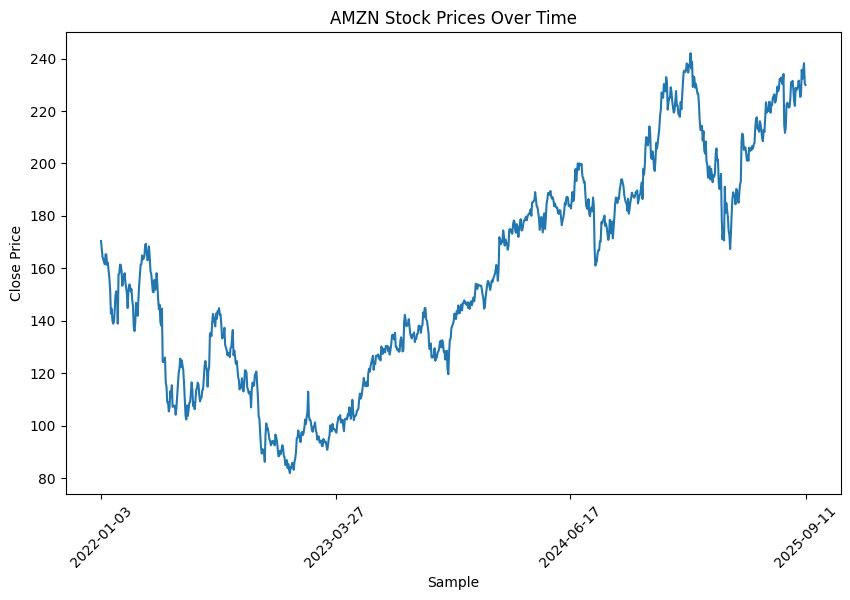

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 6))
sns.lineplot(data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close')
plt.xticks(ticks=np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int),rotation=45)
plt.title('AMZN Stock Prices Over Time')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.show()

In [158]:
# Filter
from core.data_preparator import DataPreparator
import numpy as np

AMZN_periodic_data_filtered = DataPreparator.apply_kalman_filter(
    AMZN_periodic_data,
    F=np.array([[1, 1], [0, 1]]),
    H=np.array([[1, 0]]),
    Q=np.array([[1, 0], [0, 3]])*0.01,
    R=np.array([[10]]),
    P=np.array([[1, 0], [0, 1]])*1000,
)

 2025-10-25 14:32:42 - data_preparator - INFO - Applying Kalman filter to target column: Close


In [159]:
from core.data_preparator import DataPreparator

timesteps_lookback = 3

AMZN_supervised_data = DataPreparator.reformat_periodic_to_supervised_data(
    dataframe=AMZN_periodic_data_filtered,
    target_column='Close',
    t=timesteps_lookback
)



 2025-10-25 14:32:43 - data_preparator - INFO - Preparing data for target column: Close, with t=3


In [160]:
# Attach original (unfiltered) Close for evaluation by aligned index
AMZN_supervised_data['Close_original'] = AMZN_periodic_data.loc[AMZN_supervised_data.index, 'Close'].astype(float).values
AMZN_supervised_data.head()

,Close,Close_0,Close_1,Close_2,Close_original
Date,,,,,
2022-01-06,162.710617,164.438725,167.576142,170.404495,163.253998
2022-01-07,161.637244,162.710617,164.438725,167.576142,162.554001
2022-01-10,160.614620,161.637244,162.710617,164.438725,161.485992
2022-01-11,161.921718,160.614620,161.637244,162.710617,165.362000
2022-01-12,162.735658,161.921718,160.614620,161.637244,165.207001


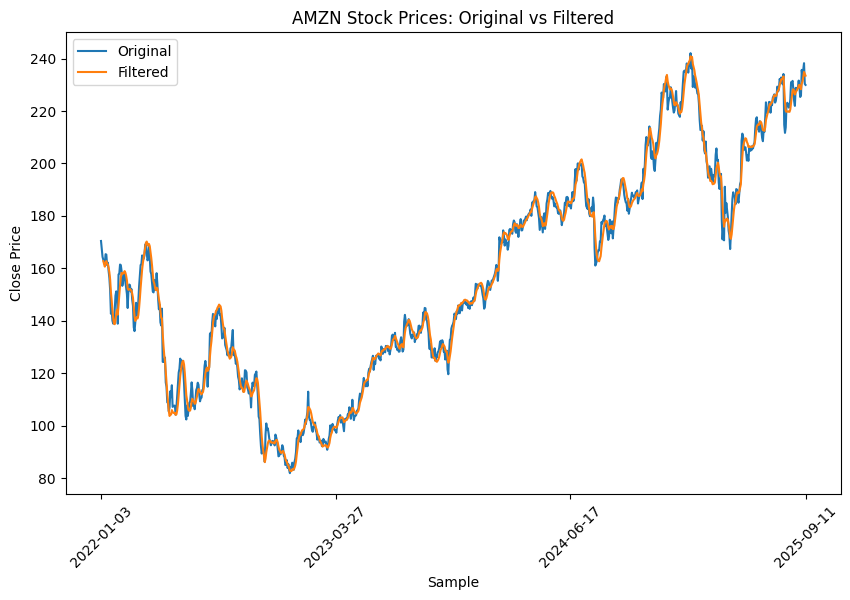

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 6))
sns.lineplot(data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close', label='Original')
sns.lineplot(data=AMZN_supervised_data, x=AMZN_supervised_data.index, y='Close', label='Filtered')
plt.xticks(ticks=np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int),rotation=45)
plt.title('AMZN Stock Prices: Original vs Filtered')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [162]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [163]:
AMZN_train_original = AMZN_train_dataset['Close_original']
AMZN_validation_original = AMZN_validation_dataset['Close_original']
AMZN_test_original = AMZN_test_dataset['Close_original']

AMZN_supervised_data.drop(columns=['Close_original'], inplace=True)
AMZN_train_dataset.drop(columns=['Close_original'], inplace=True)
AMZN_validation_dataset.drop(columns=['Close_original'], inplace=True)
AMZN_test_dataset.drop(columns=['Close_original'], inplace=True)

In [164]:
target = 'Close'
features = [col for col in AMZN_supervised_data.columns if col != target]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(AMZN_train_dataset[features])
scaler_y.fit(AMZN_train_dataset[[target]])

X_train_scaled = scaler_X.transform(AMZN_train_dataset[features])
y_train_scaled = scaler_y.transform(AMZN_train_dataset[[target]])

X_validation_scaled = scaler_X.transform(AMZN_validation_dataset[features])
y_validation_scaled = scaler_y.transform(AMZN_validation_dataset[[target]])

X_test_scaled = scaler_X.transform(AMZN_test_dataset[features])
y_test_scaled = scaler_y.transform(AMZN_test_dataset[[target]])

AMZN_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
AMZN_train_scaled[target] = y_train_scaled

AMZN_validation_scaled = pd.DataFrame(X_validation_scaled, columns=features)
AMZN_validation_scaled[target] = y_validation_scaled

AMZN_test_scaled = pd.DataFrame(X_test_scaled, columns=features)
AMZN_test_scaled[target] = y_test_scaled

AMZN_train_dataset = AMZN_train_scaled
AMZN_validation_dataset = AMZN_validation_scaled
AMZN_test_dataset = AMZN_test_scaled

In [165]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset)
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset)
AMZN_test_dataset = StockDataset(AMZN_test_dataset)

 2025-10-25 14:32:45 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-25 14:32:45 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-25 14:32:45 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close


In [166]:
from models.lstm_model import LSTMStockModel
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
import torch



def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 60, 80)
    layer_dim = trial.suggest_int('layer_dim', 2, 3)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.0015)
    epochs = trial.suggest_int('epochs', 40, 60)
    
    AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=True)
    
    model = LSTMStockModel(
        id='base_amzn_model',
        ticker='AMZN',
        input_dim=1,
        hidden_dim=hidden_dim,
        layer_dim=layer_dim,
        output_dim=1
    )
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_function = MSELoss()
    
    model.train()
    for epoch in range(epochs):
        for X,y in AMZN_train_data_loader:
            optimizer.zero_grad()
            X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1) # Adjust for t
            outputs, _ = model(X)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()
            
    AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=16, shuffle=True)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in AMZN_validation_data_loader:
            X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
            outputs, _ = model(X)
            loss = loss_function(outputs, y)
            val_loss += loss.item()
            
    average_validation_loss = val_loss / len(AMZN_validation_data_loader)
    return average_validation_loss
            

In [167]:
# import optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)
# print(f'Best hyperparameters: {study.best_params}, Best MSE Loss: {study.best_value}')

In [168]:
from models.lstm_model import LSTMStockModel

AMZN_base_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=27,
    layer_dim=1,
    output_dim=1
)

 2025-10-25 14:32:45 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=27,
layer_dimension=1,
output_dimension=1)


In [169]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(AMZN_base_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [170]:
from torch.utils.data import DataLoader
import torch
import numpy as np


AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)


train_rmse_list = []
val_rmse_list = []

predictions = []
actuals = []
epochs = 20

for epoch in range(epochs):
    # Training loop
    AMZN_base_model.train()
    train_loss = 0
    for X,y in AMZN_train_data_loader:
        optimizer.zero_grad()
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1) # Adjust for t
        outputs, _ = AMZN_base_model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions.extend(outputs.detach().numpy().flatten())
        actuals.extend(y.numpy().flatten())
        
    # Validation loop
    AMZN_base_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X,y in AMZN_validation_data_loader:
            X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
            outputs, _ = AMZN_base_model(X)
            val_loss += loss_function(outputs, y).item()
            
    train_mse = train_loss / len(AMZN_train_data_loader)
    train_rmse = np.sqrt(train_mse)
    val_mse = val_loss / len(AMZN_validation_data_loader)
    val_rmse = np.sqrt(val_mse)
    
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
        
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'Train MSE: {train_mse:.6f}')
    print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Validation MSE: {val_mse:.6f}')
    print(f'Validation RMSE: {val_rmse:.4f}')

Epoch [1/20]
Train MSE: 0.148712
Train RMSE: 0.3856
Validation MSE: 0.493425
Validation RMSE: 0.7024


Epoch [2/20]
Train MSE: 0.066119
Train RMSE: 0.2571
Validation MSE: 0.245528
Validation RMSE: 0.4955
Epoch [3/20]
Train MSE: 0.063584
Train RMSE: 0.2522
Validation MSE: 0.199142
Validation RMSE: 0.4463
Epoch [4/20]
Train MSE: 0.050028
Train RMSE: 0.2237
Validation MSE: 0.139799
Validation RMSE: 0.3739
Epoch [5/20]
Train MSE: 0.039218
Train RMSE: 0.1980
Validation MSE: 0.085141
Validation RMSE: 0.2918
Epoch [6/20]
Train MSE: 0.027300
Train RMSE: 0.1652
Validation MSE: 0.036779
Validation RMSE: 0.1918
Epoch [7/20]
Train MSE: 0.015412
Train RMSE: 0.1241
Validation MSE: 0.007207
Validation RMSE: 0.0849
Epoch [8/20]
Train MSE: 0.006165
Train RMSE: 0.0785
Validation MSE: 0.000737
Validation RMSE: 0.0271
Epoch [9/20]
Train MSE: 0.001884
Train RMSE: 0.0434
Validation MSE: 0.001105
Validation RMSE: 0.0332
Epoch [10/20]
Train MSE: 0.001042
Train RMSE: 0.0323
Validation MSE: 0.000893
Validation RMSE: 0.0299
Epoch [11/20]
Train MSE: 0.001021
Train RMSE: 0.0320
Validation MSE: 0.000828
Validation R

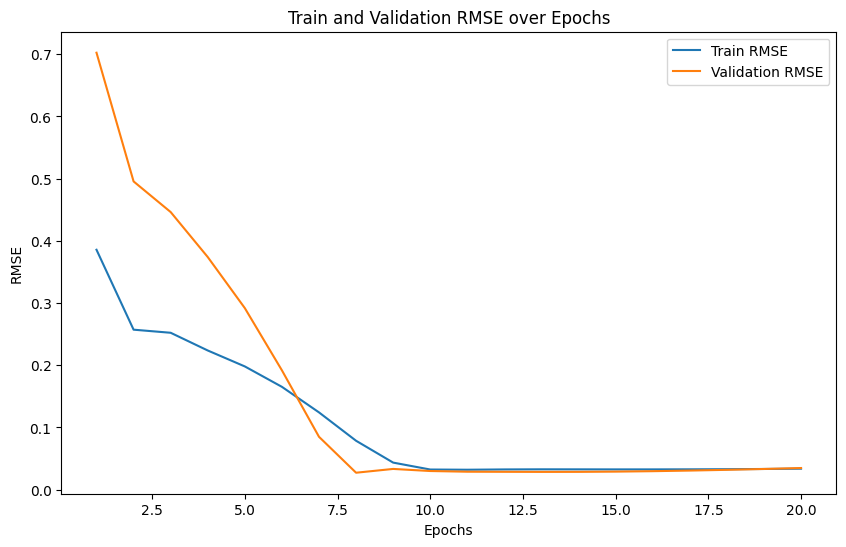

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs_range, y=train_rmse_list, label='Train RMSE')
sns.lineplot(x=epochs_range, y=val_rmse_list, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Validation RMSE over Epochs')
plt.legend()
plt.show()

In [172]:
AMZN_base_model.eval()
AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)
test_loss = 0

predictions = []
actuals = []

with torch.no_grad():
    for X,y in AMZN_test_data_loader:
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
        outputs, _ = AMZN_base_model(X)
        test_loss += loss_function(outputs, y).item()
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(y.numpy().flatten())

test_rmse = np.sqrt(test_loss / len(AMZN_test_data_loader))
print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 0.0342


Test Loss (RMSE) on original scale: 3.8255


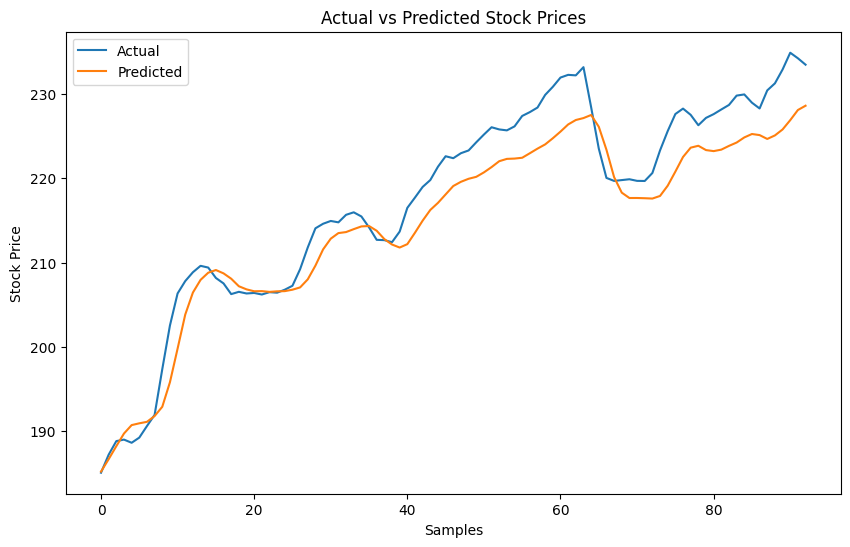

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

original_test_loss = np.sqrt(loss_function(torch.tensor(predictions), torch.tensor(actuals)).item())
print(f'Test Loss (RMSE) on original scale: {original_test_loss:.4f}')

errors = actuals - predictions

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(actuals)), y=actuals, label='Actual')
sns.lineplot(x=range(len(predictions)), y=predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

[184.41999817 190.19999695 189.97999573 186.3500061  185.00999451
 188.71000671 192.08000183 193.05999756 208.63999939 211.36999512
 210.25       205.16999817 205.58999634 206.16000366 204.07000732
 201.11999512 203.1000061  200.99000549 206.02000427 204.72000122
 205.69999695 205.00999451 206.6499939  205.71000671 207.22999573
 207.91000366 213.57000732 216.97999573 217.61000061 213.19999695
 213.24000549 212.1000061  216.1000061  214.82000732 212.52000427
 209.69000244 208.47000122 212.77000427 211.99000549 217.11999512
 223.30000305 219.38999939 220.46000671 219.91999817 223.41000366
 223.47000122 219.36000061 222.53999329 222.25999451 225.02000427
 225.69000244 226.3500061  223.19000244 223.88000488 226.13000488
 229.30000305 227.47000122 228.28999329 232.22999573 231.44000244
 232.78999329 231.00999451 230.19000244 234.11000061 214.75
 211.6499939  213.75       222.30999756 223.13000488 222.69000244
 221.30000305 221.47000122 224.55999756 230.97999573 231.02999878
 231.49000549 22

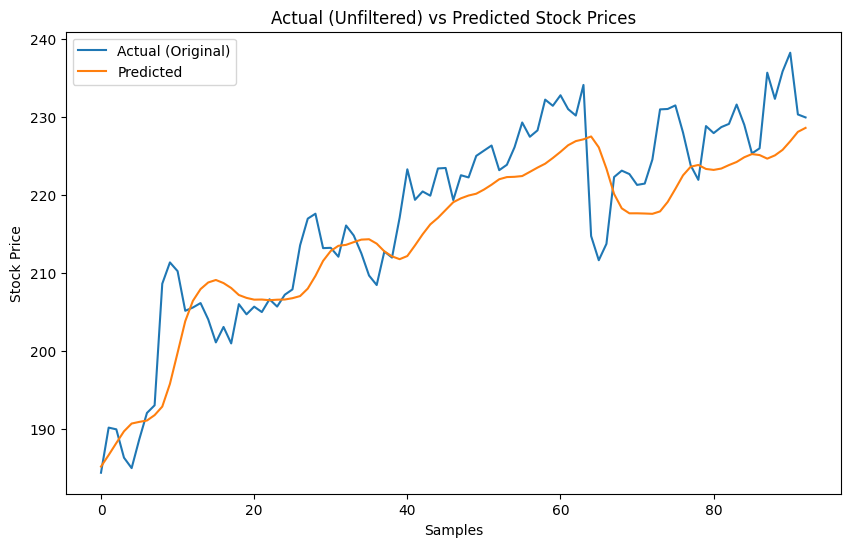

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

actuals_original = AMZN_test_original.values
print(actuals_original)

unfiltered_test_loss = np.sqrt(loss_function(torch.tensor(predictions), torch.tensor(actuals_original)).item())
print(f'Test Loss (RMSE) on unfiltered original scale: {unfiltered_test_loss:.4f}')

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(actuals_original)), y=actuals_original, label='Actual (Original)')
sns.lineplot(x=range(len(predictions)), y=predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.title('Actual (Unfiltered) vs Predicted Stock Prices')
plt.legend()
plt.show()

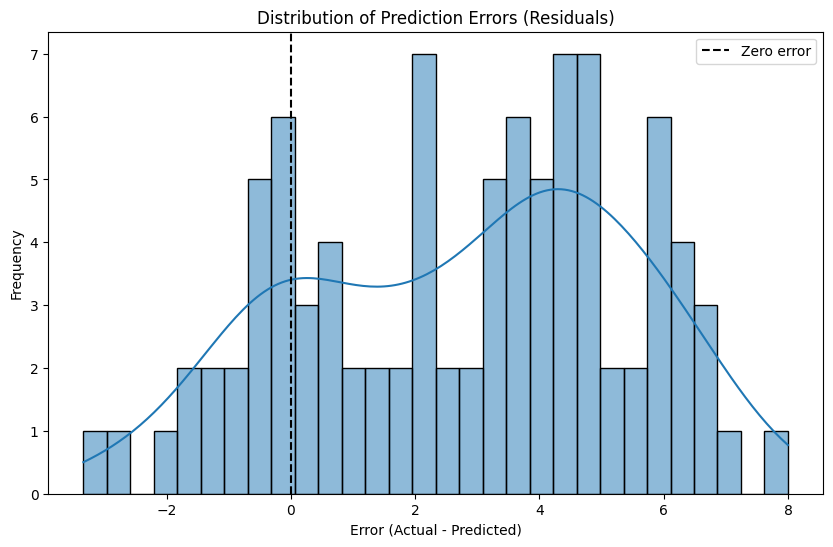

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(0, color='black', linestyle='--', label='Zero error')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

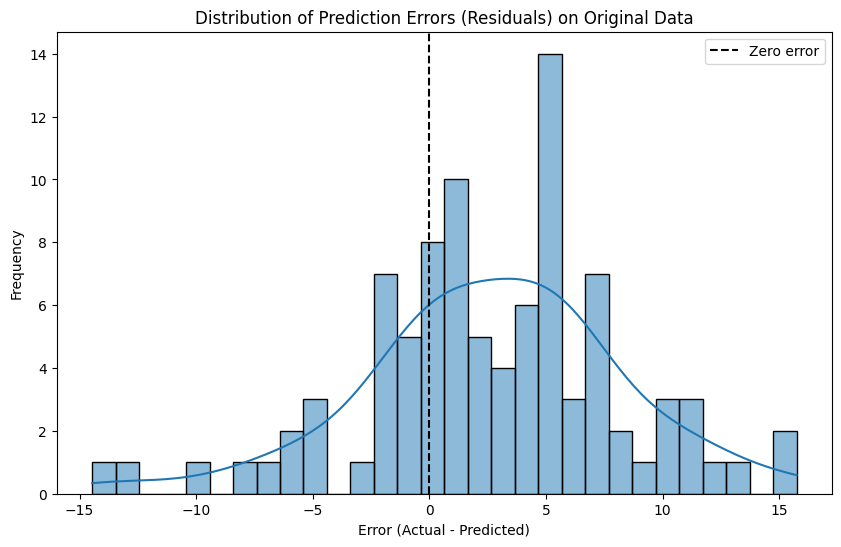

In [176]:
errors_original = actuals_original - predictions
plt.figure(figsize=(10, 6))
sns.histplot(errors_original, bins=30, kde=True)
plt.axvline(0, color='black', linestyle='--', label='Zero error')
plt.title('Distribution of Prediction Errors (Residuals) on Original Data')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()